In [34]:
from typing import Dict

import re # regular expressions

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

import warnings
warnings.filterwarnings("ignore")

### Importing the Dataset

In [2]:
with open("Cell_Phones_&_Accessories.txt", "r") as raw_data_file:
    raw_data = raw_data_file.read()
raw_rows = raw_data.split("\n\n")
len(raw_rows)

78931

In [3]:
def process_raw(review_string: str) -> Dict[str,str]:
    review_dict = {}
    for line in review_string.split("\n"):
        if line.strip() == "":
            continue
        key_value_pair = line.strip().split(":")
        key = key_value_pair[0].strip()
        value = key_value_pair[1] if len(key_value_pair) == 2 else None
        review_dict[key] = value
    return review_dict

In [4]:
dict_rows = [process_raw(row) for row in raw_rows]
df = pd.DataFrame(dict_rows[:-1])
df["review/score"] = df["review/score"].astype(float)

In [5]:
print(f"Number of rows: {len(df)}")

Number of rows: 78930


In [6]:
print(f"Colums: {[column for column in df.columns]}")

Colums: ['product/productId', 'product/title', 'product/price', 'review/userId', 'review/profileName', 'review/helpfulness', 'review/score', 'review/time', 'review/summary', 'review/text']


In [7]:
df.head()

,product/productId,product/title,product/price,review/userId,review/profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoo...,unknown,A1RXYH9ROBAKEZ,A. Igoe,0/0,1.0,1233360000,Don't buy!,"First of all, the company took my money and s..."
1,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoo...,unknown,A7L6E1KSJTAJ6,Steven Martz,0/0,5.0,1191456000,Mobile Action Bluetooth Mobile Phone Tool Sof...,Great product- tried others and this is a ten...
2,B000JVER7W,Mobile Action MA730 Handset Manager - Bluetoo...,unknown,A2NOQQ7I6PU7CW,"Daniel M. Johnson ""rocknbluesharp""",0/0,4.0,1186704000,good,works real good....a little hard to set up......
3,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, ...",unknown,A29Q0CLOF0U8BN,E. Owens,4/5,4.0,1146182400,No instructions included...,None
4,B000924R5I,"USB Data Cable for Sony-Ericsson Z600, Z500, ...",unknown,ANNHJND2MHUI3,"Isaac Salas ""=CRBF=gB^link""",0/0,1.0,1173657600,NOT A DATA CABLE,this is NOT a DATA CABLE this is only a USB c...


| feature name | feature type | comments |
| --- | --- | --- |
| product/productId |categorical | product id|
| product/title | text | product name |
| product/price | numerical | product price |
| review/userId | categorical | unique if of the user that write review |
| review/profileName | text | username of the user that write review |
| review/helpfulness | numerical | usefullnes of the review |
| review/score | categorical | target variable, 1 to 5 |
| review/time | numerical  | review date |
| review/summary | text | summary of review, short text |
| review/text | text | review message, useful for classification |

### NA analisis

In [8]:
df = df.replace(" unknown", None)

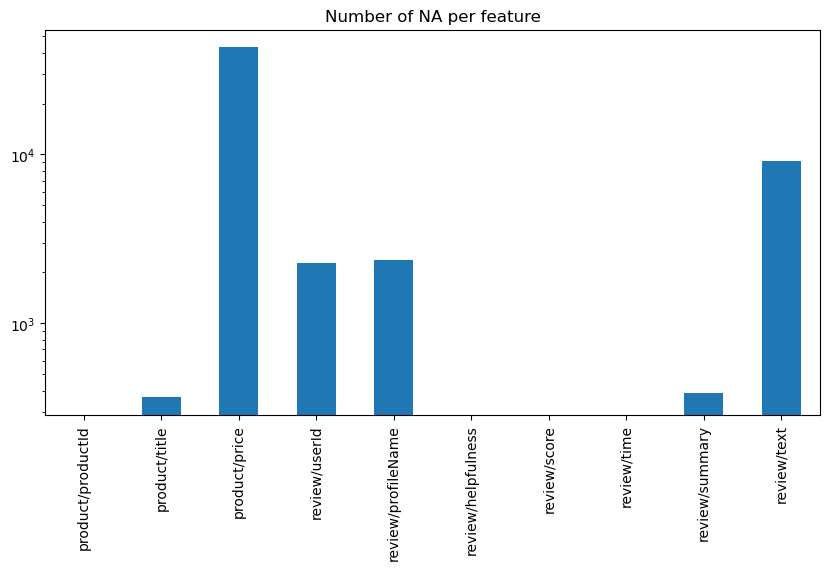

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
df.isnull().sum().plot.bar(ax=ax)
ax.set_yscale("log")
ax.set_title("Number of NA per feature")
plt.show()

### review/score Distribution

We can create a histogram to see the distribution of ratings in the dataset:

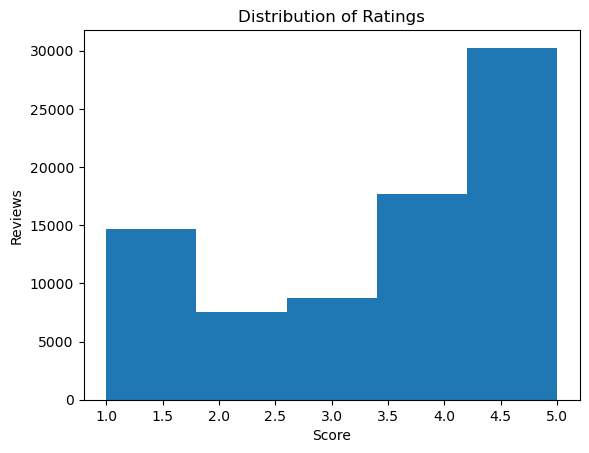

In [10]:
import matplotlib.pyplot as plt

plt.hist(df['review/score'].sort_values(), bins=5)
plt.xlabel('Score')
plt.ylabel('Reviews')
plt.title('Distribution of Ratings')
plt.show()


From this histogram, we can see that the majority of ratings are 5,4 and 1. 2 and 3 are less represented.

Probably, people tend to give binary opinions. We have lots of 4s because it is a safe choise where product is good but not excelent.

### Number of Reviews per User

The boxplot shows that most users have written only a few reviews, while a few users have written a large number of reviews.

count    68040.000000
mean         1.126602
std          0.626242
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         44.000000
dtype: float64


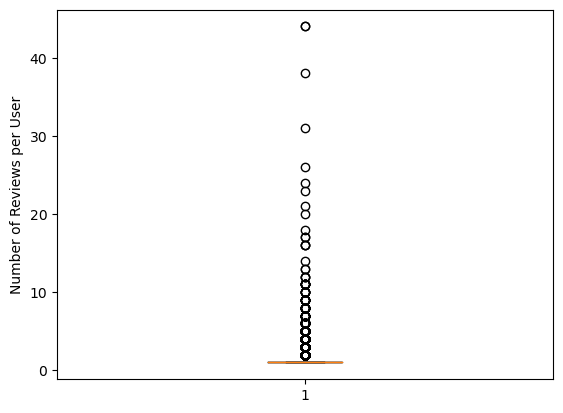

In [11]:
reviews_per_user = df.groupby('review/userId').size()
print(reviews_per_user.describe())

plt.boxplot(reviews_per_user)
plt.ylabel('Number of Reviews per User')
plt.show()


#### Top 10 reviewers

In [12]:
top_reviewers = df['review/userId'].value_counts().nlargest(10)
print(top_reviewers)

 A1RCGK44YXNBBB    44
 A5JLAU2ARJ0BO     44
 A2C8IPPOF90CJG    38
 A33FS5H3CPDR6D    31
 A4IX5FZOWQVQN     26
 A3ILVGZSKUCC5Z    24
 A149RNR5RH19YY    23
 AJMBX04BZWPSD     21
 A1SFCPHZK18NEH    20
 A2KRKPJBMHION0    18
Name: review/userId, dtype: int64


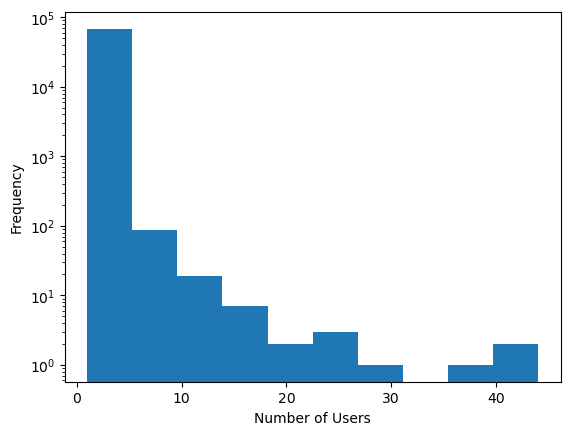

In [13]:
plt.hist(df['review/userId'].value_counts())
plt.yscale("log")
plt.xlabel('Number of Users')
plt.ylabel('Frequency')
plt.show()

### Number of Reviews per Product

Similarly, we can look at the number of reviews per product:

count    7438.000000
mean       10.611724
std        53.478478
min         1.000000
25%         1.000000
50%         2.000000
75%         6.000000
max      3443.000000
dtype: float64


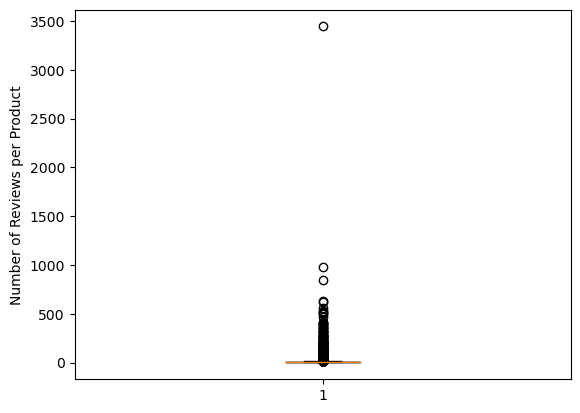

In [14]:
reviews_per_product = df.groupby("product/productId").size()
print(reviews_per_product.describe())

plt.boxplot(reviews_per_product)
plt.ylabel('Number of Reviews per Product')
plt.show()

The boxplot shows that most products have only a few reviews, while a few products have a large number of reviews. For example the biggest outlayer B0009B0IX4 that have 3443 reviews.

#### Product popularity

We can identify the products that have the most reviews and plot a histogram of the number of reviews for each product.

 B0009B0IX4    3443
 B0007WWAGI     984
 B000GAO9T2     848
 B000CQXHOS     628
 B000RUPEOA     623
 B000NKCO5Q     558
 B00006JPFU     528
 B000Q6R4MK     515
 B000JKKE5M     509
 B0000AGRYX     501
Name: product/productId, dtype: int64


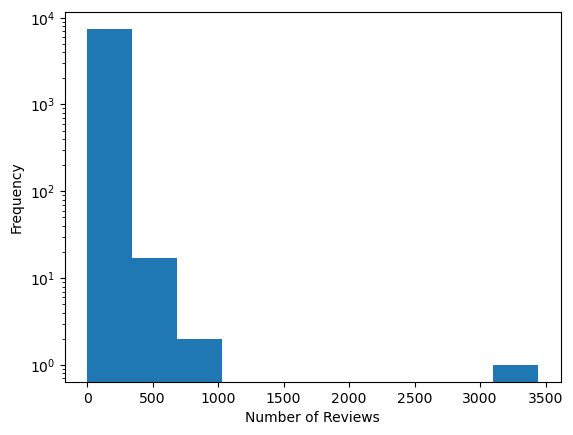

In [15]:
top_products = df['product/productId'].value_counts().nlargest(10)
print(top_products)

plt.hist(df['product/productId'].value_counts())
plt.yscale("log")
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

### Review Length

count    69758.000000
mean        85.114008
std         89.172107
min          1.000000
25%         32.000000
50%         58.000000
75%        105.000000
max       2003.000000
Name: review/text, dtype: float64


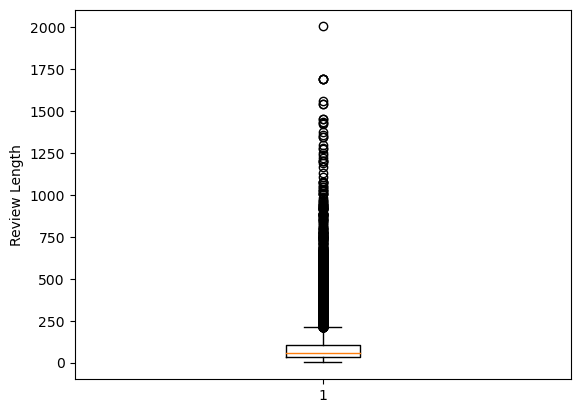

In [16]:
# Calculate review length
review_length = df['review/text'].dropna().apply(lambda x: len(x.split()))

# Summary statistics
print(review_length.describe())

# Boxplot
plt.boxplot(review_length)
plt.ylabel('Review Length')
plt.show()

The boxplot shows that most reviews are between 0 and 200 words in length, while a few reviews are much longer.

### Word Frequency

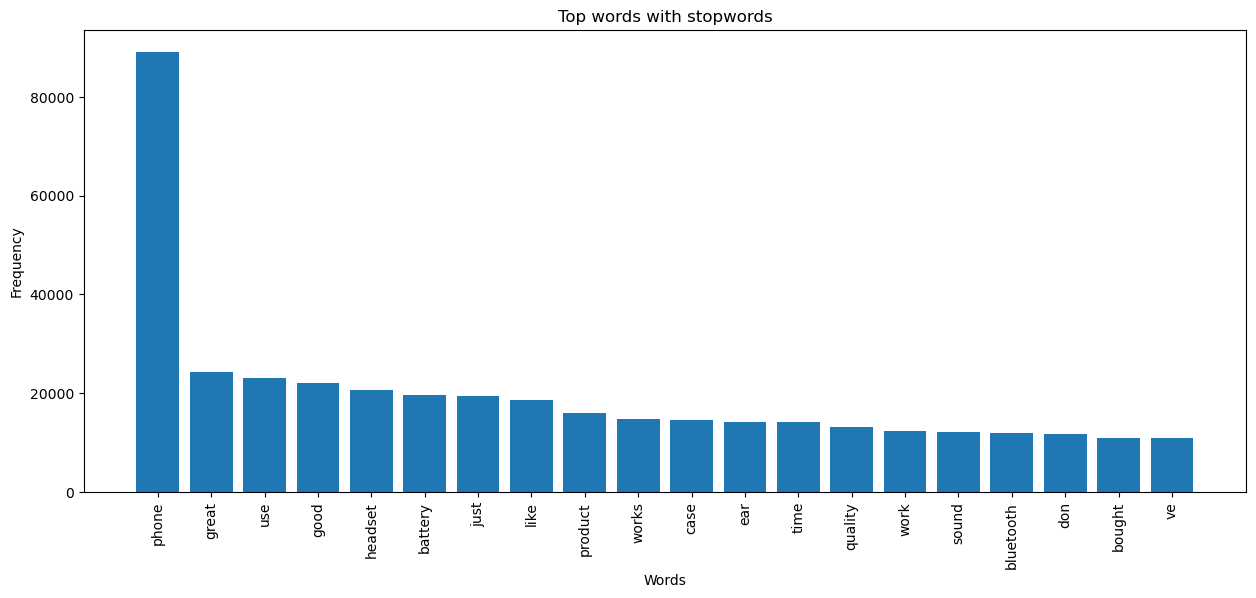

In [17]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# create a CountVectorizer object
vectorizer = CountVectorizer(stop_words='english')

# fit the vectorizer on the review text column
doc_term_matrix = vectorizer.fit_transform(df['review/text'].dropna())

# create a dataframe of word frequency counts
word_freq_df = pd.DataFrame(doc_term_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# get the top 20 most frequent words
top_words = word_freq_df.sum().sort_values(ascending=False)[:20]

# plot a histogram of the top words
plt.figure(figsize=(15,6))
plt.bar(top_words.index, top_words.values)
plt.xticks(rotation=90)
plt.title("Top words with stopwords")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


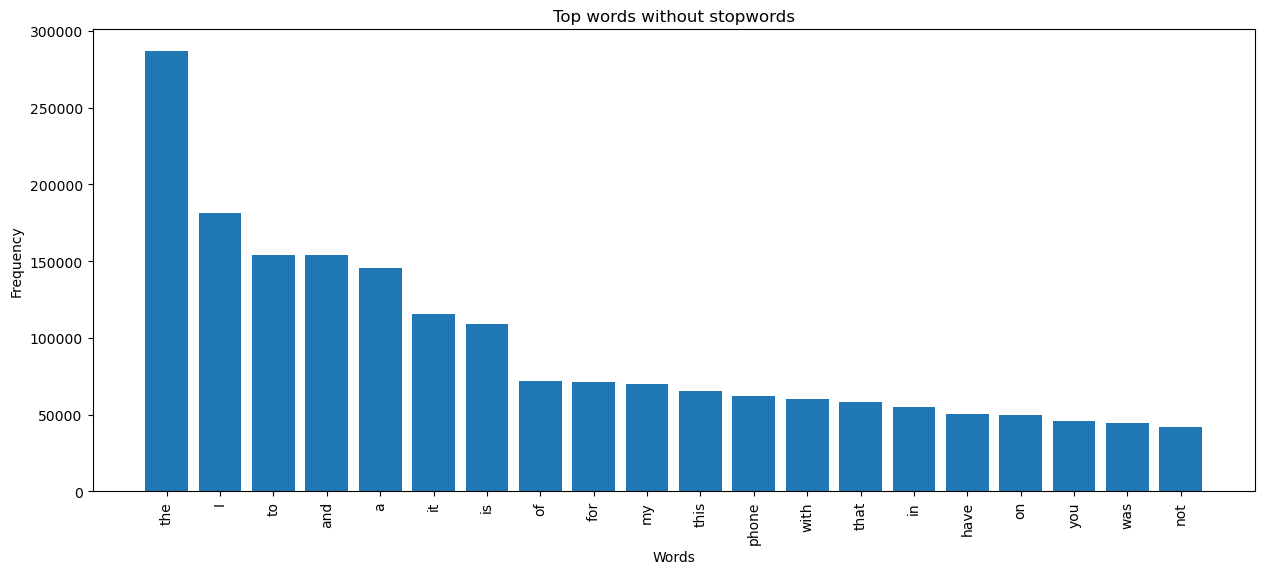

In [18]:
# Count word frequency

word_freq = Counter(" ".join(df['review/text'].dropna()).split()).most_common(20)

# Create bar chart
words, frequencies = zip(*word_freq)

plt.figure(figsize=(15,6))
plt.bar(words, frequencies)
plt.xticks(rotation=90)
plt.title("Top words without stopwords")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

The bar chart shows that the most common words in the reviews are articles, conjunctions, and prepositions, which are not very informative in terms of the content of the reviews.

### WordCloud for review score

In [19]:
def preprocess_text(text):
    text = text.lower()
    tokens = re.findall(r"\w+", text)
    tokens = [t for t in tokens if t not in stopwords]
    return list(set(tokens))


def calc_top_words(df: pd.DataFrame, text_col: str, top_n: int = 50, with_difference: bool = True):
    df_top_words = df.groupby("review/score")[text_col].apply(
        lambda x: x.dropna().apply(preprocess_text).dropna().explode().value_counts()[:top_n].index)
    if with_difference:
        for i in range(1,6):
            for j in range(1,6):
                if i != j:
                    df_top_words[i] = df_top_words[i].difference(df_top_words[j])
    df_top_words = df_top_words.apply(list)
    return df_top_words

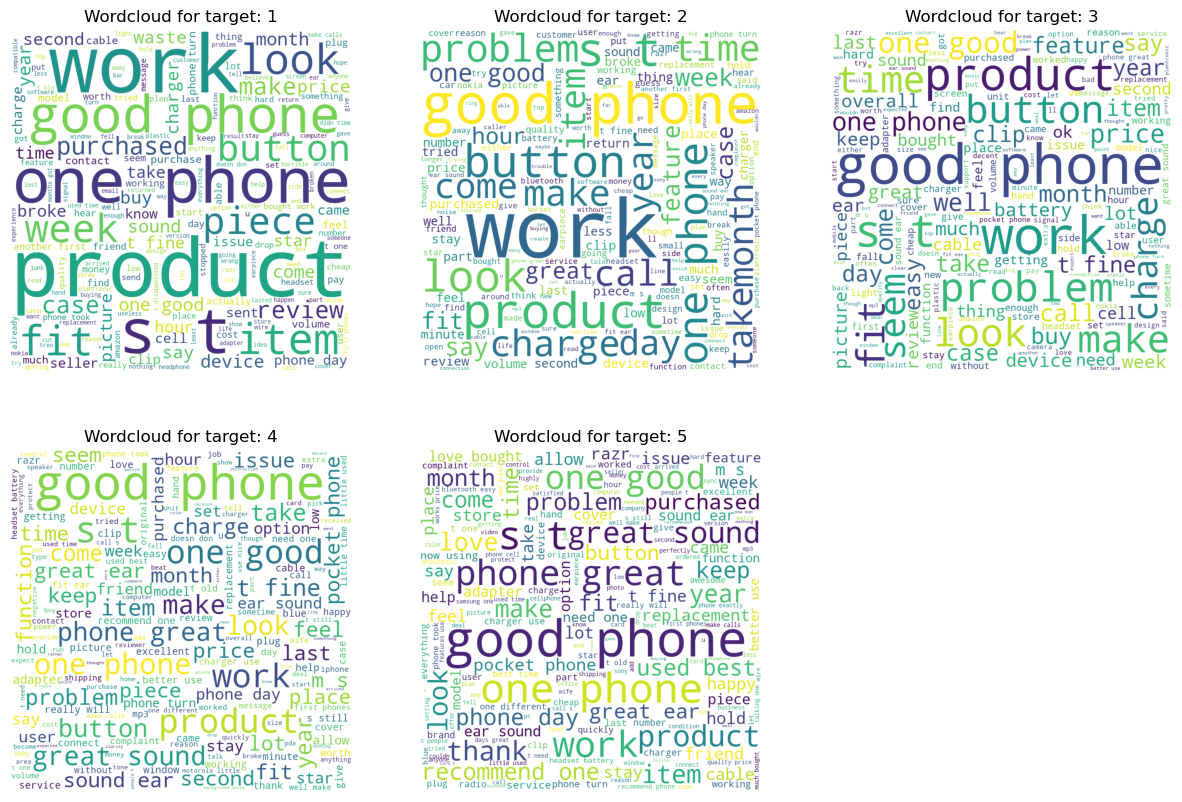

In [20]:
plt.figure(figsize = (15, 10), )
for i in range(1,6):
    tokens = " ".join(df[df["review/score"].isin([i])]["review/text"].dropna().apply(preprocess_text).explode().dropna())
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5).generate(tokens)
 
    # plot the WordCloud image
    plt.subplot(2,3,i)                      
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Wordcloud for target: {i}")

In [22]:
df_top_words = calc_top_words(df, "review/text", top_n=50)
for i in range(1,6):
    print(f"Top words that occur only for reviews with rating {i}:")
    print(df_top_words[i])
    print()

Top words that occur only for reviews with rating 1:
['amazon', 'didn', 'item', 'money', 'never', 'service', 'tried']

Top words that occur only for reviews with rating 2:
['another', 'months', 'people', 'two']

Top words that occur only for reviews with rating 3:
['3', 'back', 'call', 'doesn', 'fit', 'hear', 'way']

Top words that occur only for reviews with rating 4:
['far', 'fine', 'nice', 'overall', 'problem', 'thing']

Top words that occur only for reviews with rating 5:
['2', 'battery', 'best', 'better', 'bluetooth', 'bought', 'buy', 'car', 'case', 'cell', 'charge', 'charger', 'don', 'ear', 'easy', 'even', 'first', 'good', 'got', 'great', 'headset', 'little', 'love', 'm', 'motorola', 'much', 'need', 'new', 'now', 'one', 'phone', 'phones', 'price', 'product', 'quality', 'really', 'recommend', 's', 'sound', 'still', 't', 'time', 'use', 'used', 'using', 've', 'well', 'will', 'work', 'works']



<Axes: >

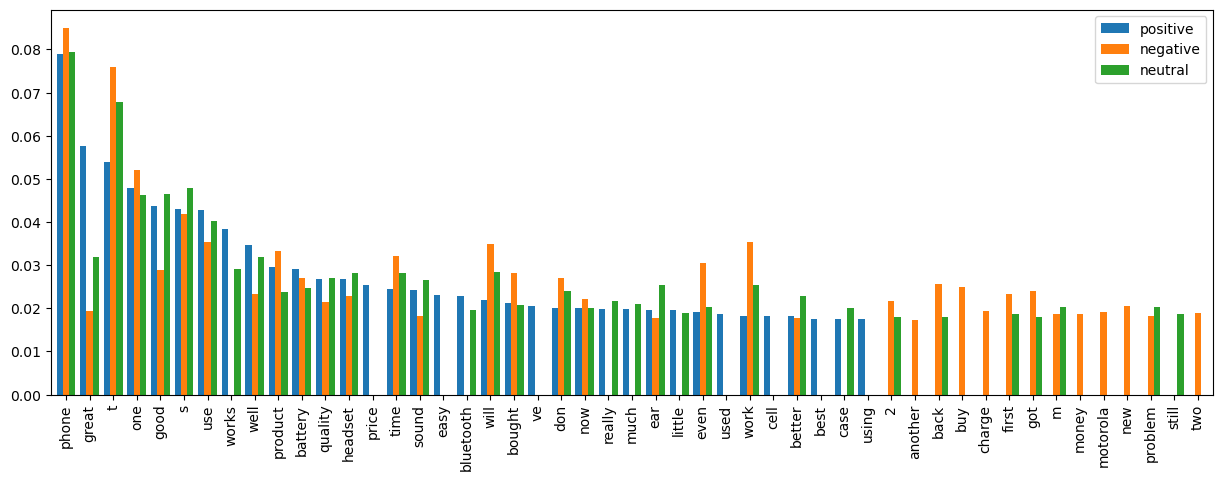

In [23]:
neg = df[df["review/score"].isin([1,2])]["review/text"].dropna().apply(preprocess_text).explode().value_counts()[:35]
neg = neg / neg.sum()
neg.name = "negative"

neut = df[df["review/score"].isin([3])]["review/text"].dropna().apply(preprocess_text).explode().value_counts()[:35]
neut = neut / neut.sum()
neut.name = "neutral"

pos = df[df["review/score"].isin([4,5])]["review/text"].dropna().apply(preprocess_text).explode().value_counts()[:35]
pos = pos / pos.sum()
pos.name = "positive"

fig = plt.figure(figsize=(15, 5))
ax = fig.subplots()
pos.to_frame().join(neg.to_frame(), how="outer").join(neut.to_frame(), how="outer").sort_values("positive", ascending=False).plot.bar(width=0.8, ax=ax)



We can observe that the distributions overlap

### Sentiment Analysis

This will perform sentiment analysis on the reviews using the VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon and create a line chart of the average sentiment over time:

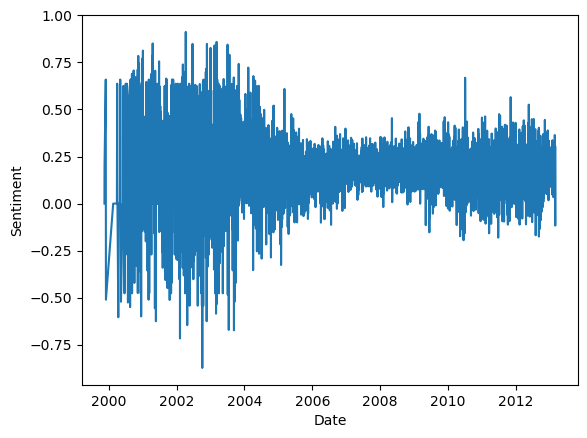

In [24]:
sia = SentimentIntensityAnalyzer()

df['sentiment'] = df['review/summary'].dropna().apply(lambda x: sia.polarity_scores(x)['compound'])

df['datetime'] = pd.to_datetime(df['review/time'], unit='s')
# Create line chart
plt.plot(df.groupby('datetime')['sentiment'].mean())
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

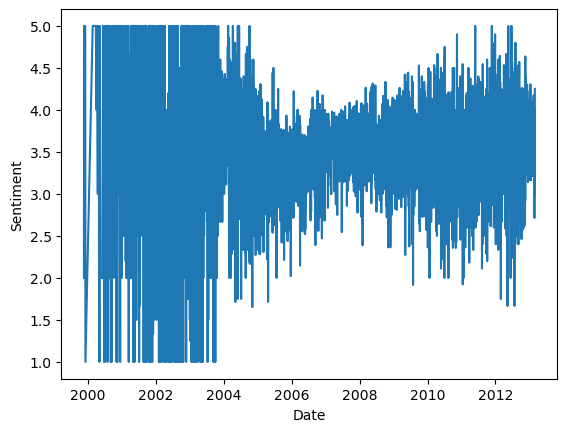

In [25]:
plt.plot(df.groupby('datetime')['review/score'].mean())
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.show()

The line chart shows that the sentiment of the reviews is generally positive, but there are some fluctuations over time.

In [27]:
reviewer_sentiment = df.groupby('review/userId')['sentiment'].mean().sort_values(ascending=False)
print(reviewer_sentiment.head(10))

review/userId
 A26ZYLGQ9HZUKR    0.9545
 A1LSRI9PY1HOOU    0.9545
 A4ZZQ85T4DSLO     0.9524
 A3DSPSJ4879ONC    0.9501
 A352HUBTVY36N7    0.9485
 AQF3D0KX5SFCM     0.9464
 A2V903JEONJP4I    0.9451
 AM1EVX4N2ZO6J     0.9439
 AD2CT7CWRW2D5     0.9413
 A1P1RS00NF7XRG    0.9410
Name: sentiment, dtype: float64


### Reccommended system (similar product) 

Find similar product based on product/title the user reviewed  

In [28]:
def recommend_products(user_id, df):
    # get user's rated products
    user_products = df[df['review/userId'] == user_id]['product/title'].unique()
    
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['product/title'].fillna(''))
    
    # calculate similarity between user's rated products and all other products
    cosine_similarities = linear_kernel(tfidf_matrix[df['product/title'].isin(user_products)], tfidf_matrix)
    
    # get indices of top similar products
    similar_indices = cosine_similarities.argsort()[:, ::-1][0]
    
    # get top similar products that user has not rated yet
    recommended_products = []
    for idx in similar_indices:
        if df.iloc[idx]['product/title'] not in user_products:
            recommended_products.append(df.iloc[idx]['product/title'])
        if len(recommended_products) == 1:
            break
    
    return recommended_products

In [29]:
user_id = " A29Q0CLOF0U8BN"
print(df[df['review/userId'] == user_id]['product/title'].unique())
recommended_products = recommend_products(user_id, df)
print(recommended_products)

[' USB Data Cable for Sony-Ericsson Z600, Z500, Z200, S700, P900, P802, P800, K700, T637, T630,T628, T618, T616, T610, T316, T310, T237, T226, T68i, T68, T62u, T39, R380 + Internet + Driver CD']
[' USB data cable for Sony-Ericsson Z600, Z500, Z200, S700, P900, P802, P800, K700, T637, T630,T628, T618, T616, T610, T316, T310, T237, T226, T68i, T68, T62u, T39, R380']


### Clustering

In [30]:
df = df[df['review/text'].notna()]
reviews = df['review/text']

In [43]:
# Convert the reviews into a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.5)
tfidf_matrix = vectorizer.fit_transform(reviews)

In [44]:
tfidf_matrix.shape

(69758, 13459)

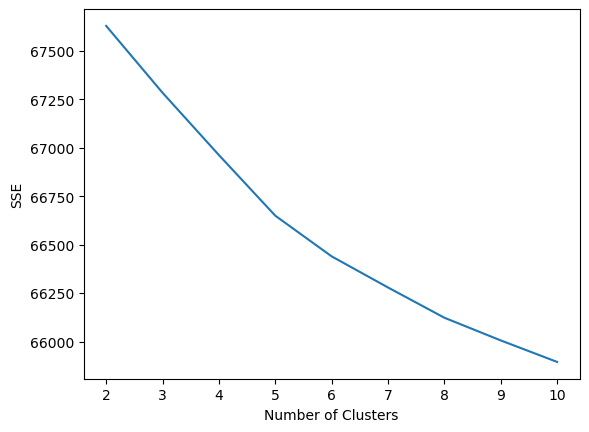

In [35]:
range_n_clusters = range(2, 11)
sse = []
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, max_iter=300)
    kmeans.fit(tfidf_matrix)
    sse.append(kmeans.inertia_)
plt.plot(range_n_clusters, sse)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

In [51]:
# Based on the elbow plot, we can see that the optimal number of clusters is 5
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)
# Get the cluster labels for each review
clusters = km.labels_.tolist()
# Create a dataframe with reviews and their respective cluster labels
reviews_clusters = {'review': reviews, 'cluster': clusters}
df_cluster = pd.DataFrame(reviews_clusters, columns=['review', 'cluster'])

In [52]:
y_pred = df_cluster["cluster"]+1
y_true = df['review/score']

In [53]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

         1.0       0.23      0.55      0.32     13457
         2.0       0.11      0.23      0.15      6540
         3.0       0.13      0.23      0.16      7346
         4.0       0.17      0.06      0.09     14946
         5.0       0.39      0.07      0.12     27469

    accuracy                           0.19     69758
   macro avg       0.20      0.23      0.17     69758
weighted avg       0.26      0.19      0.16     69758



In [39]:
# Print the top 10 reviews for each cluster
for i in range(num_clusters):
    print(f"Cluster {i}:")
    cluster_reviews = df_cluster[df_cluster['cluster'] == i]['review']
    print(cluster_reviews.head(10))
    print()

Cluster 0:
0      First of all, the company took my money and s...
1      Great product- tried others and this is a ten...
2      works real good....a little hard to set up......
4      this is NOT a DATA CABLE this is only a USB c...
5      There's not much to say about a data cable --...
6      I have a Sony Ericsson K700i, which doesn't s...
8      I currently have this item for my S/E z500a p...
10     If you purchase this data cable, you need to ...
11     This cable saves me a lot of money. I don't n...
14     Review is a few years late. Worked great when...
Name: review, dtype: object

Cluster 1:
23      I purchased this charger along with the &quot...
349     Not much to say--it's an inexpensive, effecti...
407     I like it, it's so small, just what I needed ...
452     Nice and samll but battery died on this repla...
514     I've used a bluetooth headset before but neve...
528     Hey,This product has excellent voice quality,...
536     This battery doesn't hold charge for an

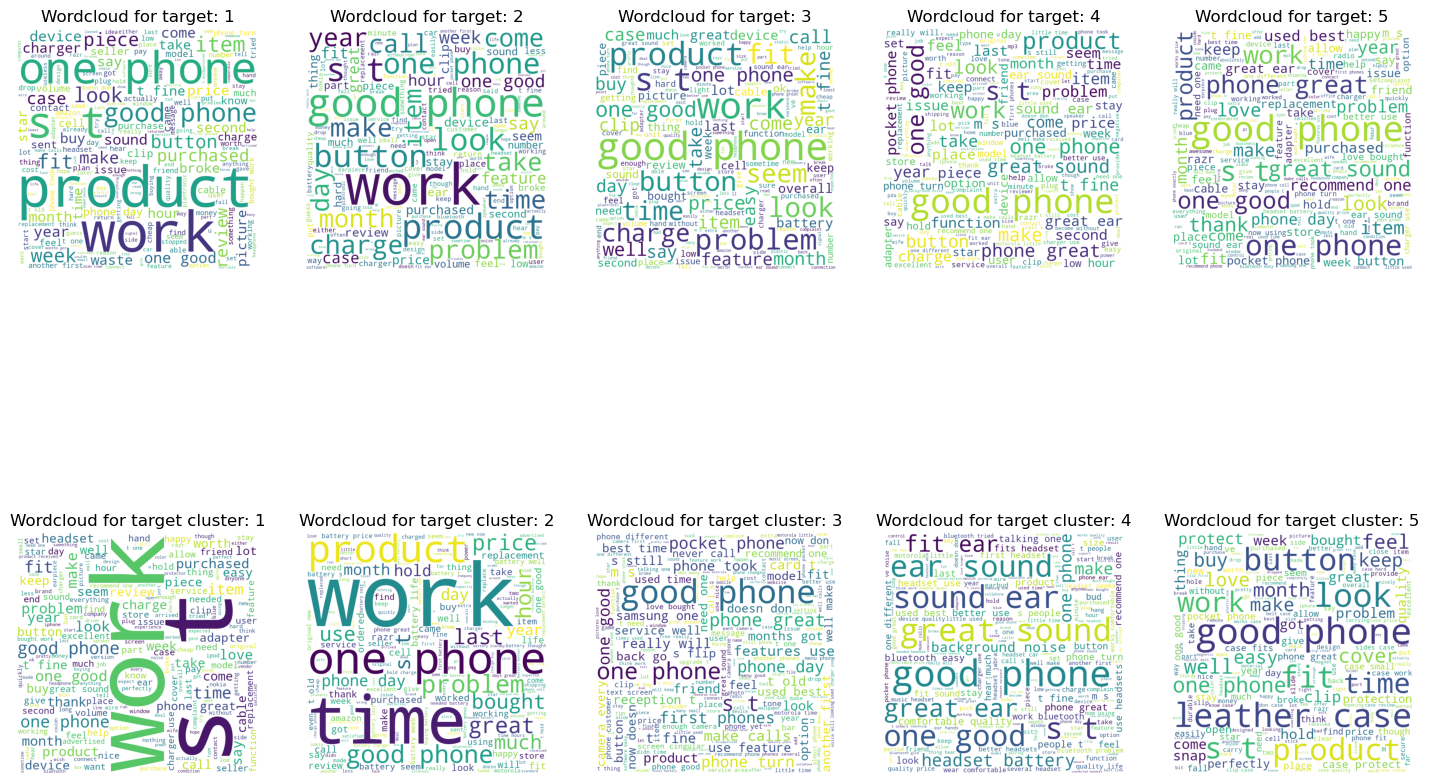

In [40]:
plt.figure(figsize = (18, 12))
for i in range(0,5):
    tokens = " ".join(df_cluster.loc[df_cluster["cluster"]==i, "review"].apply(preprocess_text).explode().dropna())
    wordcloud_c = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5).generate(tokens)
    
    tokens = " ".join(df[df["review/score"].isin([i+1])]["review/text"].dropna().apply(preprocess_text).explode().dropna())
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 5).generate(tokens)
 
    # plot the WordCloud image
    plt.subplot(2,5,i+1)                      
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Wordcloud for target: {i+1}")
    plt.subplot(2,5,i+6)
    plt.imshow(wordcloud_c)
    plt.axis("off")
    plt.title(f"Wordcloud for target cluster: {i+1}")

In [41]:
def calc_top_words_2(df: pd.DataFrame, text_col: str, top_n: int = 50, with_difference: bool = True):
    df_top_words = df.groupby("cluster")[text_col].apply(
        lambda x: x.dropna().apply(preprocess_text).dropna().explode().value_counts()[:top_n].index)
    if with_difference:
        for i in range(0,5):
            for j in range(0,5):
                if i != j:
                    df_top_words[i] = df_top_words[i].difference(df_top_words[j])
    df_top_words = df_top_words.apply(list)
    return df_top_words

In [42]:
df_top_words = calc_top_words_2(df_cluster, 'review', top_n=50)
for i in range(0,5):
    print(f"Top words that occur only for reviews with rating {i+1}:")
    print(df_top_words[i])
    print()

Top words that occur only for reviews with rating 1:
['car', 'fine', 'item', 'purchased', 'worked']

Top words that occur only for reviews with rating 2:
['3', 'amazon', 'batteries', 'came', 'charge', 'charged', 'charger', 'day', 'days', 'hold', 'hours', 'last', 'life', 'long', 'longer', 'old', 'original', 'received', 'replacement', 'two']

Top words that occur only for reviews with rating 3:
['2', 'calls', 'camera', 'cell', 'features', 'go', 'got', 'love', 'make', 'mobile', 'new', 'phones', 'reception', 'service', 'thing', 'want']

Top words that occur only for reviews with rating 4:
['battery', 'best', 'bluetooth', 'call', 'clear', 'comfortable', 'ear', 'end', 'headset', 'headsets', 'hear', 'motorola', 'noise', 'people', 'piece', 'plantronics', 'problem', 'sound', 'used', 'using', 'volume', 'work', 'works']

Top words that occur only for reviews with rating 5:
['around', 'back', 'belt', 'better', 'bought', 'buy', 'case', 'cases', 'clip', 'cover', 'doesn', 'don', 'easy', 'even', 'firs

# Conclusions:
 - Text features are the most valuable
 - From above analisis we see that data is not bad and we could try another models such as: random forest, SVM and advanced as neural networks
 - Looking on WordCloud and F1 score we see that even clustering works a little

# To Do in future:
 - Work more with text features
 - Try use both text features: summary and reviewText
 - Try to work with review/helpfulness colum (divided into two features positives and negatives)
 - Rewrite similar product to Recommender System